In [1]:
# !pip install pmdarima
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
import pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax

import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión pdarima: {pmdarima.__version__}")
print(f"{color}Versión statsmodels: {statsmodels.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

Versión skforecast: 0.12.1
Versión pdarima: 2.0.4
Versión statsmodels: 0.14.1
Versión pandas: 2.0.3
Versión numpy: 1.24.3


/home/alumno/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Guardar la variable imputation_lluvia_aitsu en otra variable para las modificaciones
variable = 'NIVEL_RIO_Aitzu-Urola'
data_river_2 = pd.read_csv('db_21.csv')
data_river_2 = data_river_2.set_index('Fecha')
# Asignar un formato de fecha a la columna fecha
data_river_2.index = pd.to_datetime(data_river_2.index, format='%Y-%m-%d %H:%M:%S')

# Se trabajara sobre la variable de nivel del rio Aitzu-Urola 
imputation_lluvia_aitsu = data_river_2[[variable]].copy()

In [8]:
#Con la siguiente funcion analizamos los datos duplicados en el indice del dataframe 
def analyze_duplicate_indices(df):
    # Identificar índices duplicados
    duplicated_indices = df.index[df.index.duplicated(keep=False)]
    
    if duplicated_indices.empty:
        print("No se encontraron índices duplicados.")
        return None

    # Ordenar los duplicados
    duplicates_sorted = df.loc[duplicated_indices].sort_index()

    # Agrupar los duplicados
    grouped_duplicates = duplicates_sorted.groupby(duplicates_sorted.index)

    duplicate_info = []

    for idx, group in grouped_duplicates:
        duplicate_info.append({
            'index': idx,
            'count': len(group),
            'values': group.values.flatten().tolist()
        })

    return duplicate_info

def remove_duplicate_indices(df, method='first'):
    # Analizar duplicados
    duplicate_info = analyze_duplicate_indices(df)
    
    if not duplicate_info:
        print("No hay índices duplicados para eliminar.")
        return df
    
    # Eliminar duplicados
    df_sin_duplicados = df[~df.index.duplicated(keep=method)]
    
    print(f"Se eliminaron {len(df) - len(df_sin_duplicados)} filas con índices duplicados.")
    print(f"Tamaño original del DataFrame: {len(df)}")
    print(f"Tamaño del DataFrame sin duplicados: {len(df_sin_duplicados)}")
    
    return df_sin_duplicados

def find_nan_sequences(df, max_consecutive_nans=120, view=False):
    nan_index = df[df.isnull().any(axis=1)].index
    # print(nan_index)
    nan_sequences = []
    
    if len(nan_index) == 0:
        return nan_sequences

    start_date = nan_index[0]
    prev_date = nan_index[0]
    
    for i in range(1, len(nan_index)):
        current_date = nan_index[i]
        
        if current_date - prev_date != pd.Timedelta('1 hour 00:00:00'):
            # No es consecutivo, guardar la secuencia anterior
            end_date = prev_date
            num_nans = (end_date - start_date).total_seconds() / 3600 + 1
            
            if num_nans == 1:
                nan_sequences.append({
                    'type': 'single',
                    'start_date': start_date,
                    'end_date': end_date,
                    'num_nans': num_nans
                })
            elif num_nans <= max_consecutive_nans:
                nan_sequences.append({
                    'type': 'consecutive',
                    'start_date': start_date,
                    'end_date': end_date,
                    'num_nans': num_nans
                })
            elif num_nans > max_consecutive_nans:
                nan_sequences.append({
                    'type': 'long_consecutive',
                    'start_date': start_date,
                    'end_date': end_date,
                    'num_nans': num_nans
                })
            else:
                if view:
                    print(f'Secuencia de NaN mayor a {max_consecutive_nans} horas: {start_date} a {end_date}, {num_nans} valores')
            
            # Iniciar una nueva secuencia
            start_date = current_date
        
        prev_date = current_date
    
    # Manejar la última secuencia
    end_date = prev_date
    num_nans = (end_date - start_date).total_seconds() / 3600 + 1
    
    if num_nans == 1:
        nan_sequences.append({
            'type': 'single',
            'date': start_date
        })
    elif num_nans <= max_consecutive_nans:
        nan_sequences.append({
            'type': 'consecutive',
            'start_date': start_date,
            'end_date': end_date,
            'num_nans': num_nans
        })
    else:
        if view:
            print(f'Secuencia de NaN mayor a {max_consecutive_nans} horas: {start_date} a {end_date}, {num_nans} valores')
    
    return nan_sequences

In [9]:
# Usar la función
duplicate_info = analyze_duplicate_indices(imputation_lluvia_aitsu)

# Usar la función
imputation_lluvia_aitsu_sin_duplicados = remove_duplicate_indices(imputation_lluvia_aitsu, method='first')

# Uso de la función
nan_sequences = find_nan_sequences(imputation_lluvia_aitsu_sin_duplicados, max_consecutive_nans=120, view=True)

# Imprimir resultados
for x in nan_sequences:
    print(x)

No se encontraron índices duplicados.
No se encontraron índices duplicados.
No hay índices duplicados para eliminar.
Secuencia de NaN mayor a 120 horas: 2023-10-01 00:00:00 a 2024-12-31 23:00:00, 10992.0 valores
{'type': 'long_consecutive', 'start_date': Timestamp('1999-01-01 00:00:00'), 'end_date': Timestamp('1999-03-16 16:00:00'), 'num_nans': 1793.0}
{'type': 'single', 'start_date': Timestamp('2002-01-08 00:00:00'), 'end_date': Timestamp('2002-01-08 00:00:00'), 'num_nans': 1.0}
{'type': 'consecutive', 'start_date': Timestamp('2003-02-05 12:00:00'), 'end_date': Timestamp('2003-02-05 23:00:00'), 'num_nans': 12.0}
{'type': 'single', 'start_date': Timestamp('2004-11-04 08:00:00'), 'end_date': Timestamp('2004-11-04 08:00:00'), 'num_nans': 1.0}
{'type': 'long_consecutive', 'start_date': Timestamp('2006-09-06 08:00:00'), 'end_date': Timestamp('2006-09-22 14:00:00'), 'num_nans': 391.0}
{'type': 'consecutive', 'start_date': Timestamp('2009-02-03 17:00:00'), 'end_date': Timestamp('2009-02-06 1

In [11]:
x = 1
init_train = nan_sequences[0]['end_date'] + pd.Timedelta('1 hour 00:00:00')
end_train = nan_sequences[x]['start_date'] - pd.Timedelta('1 hour 00:00:00')
# init_train = '2000-01-01 00:00:00'
# end_train = '2022-01-01 00:00:00'
datos = imputation_lluvia_aitsu_sin_duplicados[init_train:end_train]
print('Fecha de inicio para el entrenamiento ----> ', datos.index[0])
print('Fecha de fin del entrenamiento ------> ', datos.index[-1])
# fecha_inicial = '2000-01-01 00:00:00'
# fecha_final = '2002-01-01 00:00:00'
# datos = datos[fecha_inicial:fecha_final]

fin_train = '2001-01-07 23:59:59'
print(
    f"Fechas train : {datos.index.min()} --- {datos.loc[:fin_train].index.max()}  "
    f"(n={len(datos.loc[:fin_train])})"
)
print(
    f"Fechas test  : {datos.loc[fin_train:].index.min()} --- {datos.loc[:].index.max()}  "
    f"(n={len(datos.loc[fin_train:])})"
)
datos_train = datos.loc[:fin_train]
datos_test  = datos.loc[fin_train:]

Fecha de inicio para el entrenamiento ---->  1999-03-16 17:00:00
Fecha de fin del entrenamiento ------>  2002-01-07 23:00:00
Fechas train : 1999-03-16 17:00:00 --- 2001-01-07 23:00:00  (n=15919)
Fechas test  : 2001-01-08 00:00:00 --- 2002-01-07 23:00:00  (n=8760)


(array([ 57.,  45.,   9.,  22.,   7.,  40.,  47.,  29.,  51.,  51.,  58.,
        238., 262., 210., 361., 326., 364., 300., 549., 478., 302., 380.,
        409., 298., 249., 284., 514., 269., 340., 407., 337., 294., 351.,
        512., 228., 224., 273., 318., 231., 216., 243., 463., 211., 204.,
        217., 188., 158., 200., 322., 167., 149., 171., 137., 156., 149.,
        280., 169., 167., 180., 160., 122.,  84., 116., 236., 176., 185.,
        129., 160., 170., 161., 178., 177., 164., 140., 162., 169., 165.,
         84., 176., 104., 104., 104., 128., 158.,  98., 195., 118.,  85.,
         88., 159., 132., 115., 160., 276.,  95., 124.,  99., 137.,  71.,
         98., 235.,  82.,  86.,  93., 107.,  75.,  67., 101., 153.,  81.,
         63.,  87.,  50.,  72.,  69., 137.,  62.,  74.,  90.,  70.,  60.,
         66.,  48.,  83.,  47.,  59.,  76.,  49.,  58.,  50.,  74.,  37.,
         45.,  30.,  43.,  41.,  54.,  42.,  78.,  44.,  26.,  28.,  27.,
         26.,  38.,  63.,  34.,  21., 

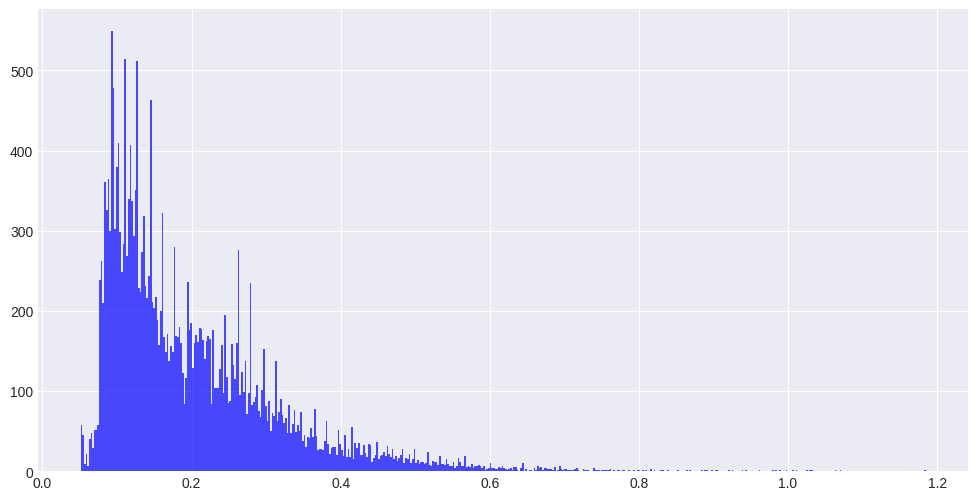

In [13]:
datos.describe()
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.hist(datos, bins=500, color='blue', alpha=0.7, label='Datos')

In [ ]:
warnings.filterwarnings("ignore")

datos.dropna(inplace=True)

datos_diff_1 = datos_train.diff().dropna()
datos_diff_2 = datos_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(datos)
kpss_result = kpss(datos)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(datos.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(datos.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 15), sharex=True)
datos.plot(ax=axs[0], title='Serie original')
datos_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
datos_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');

Test estacionariedad serie original
-------------------------------------


ValueError: zero-size array to reduction operation maximum which has no identity

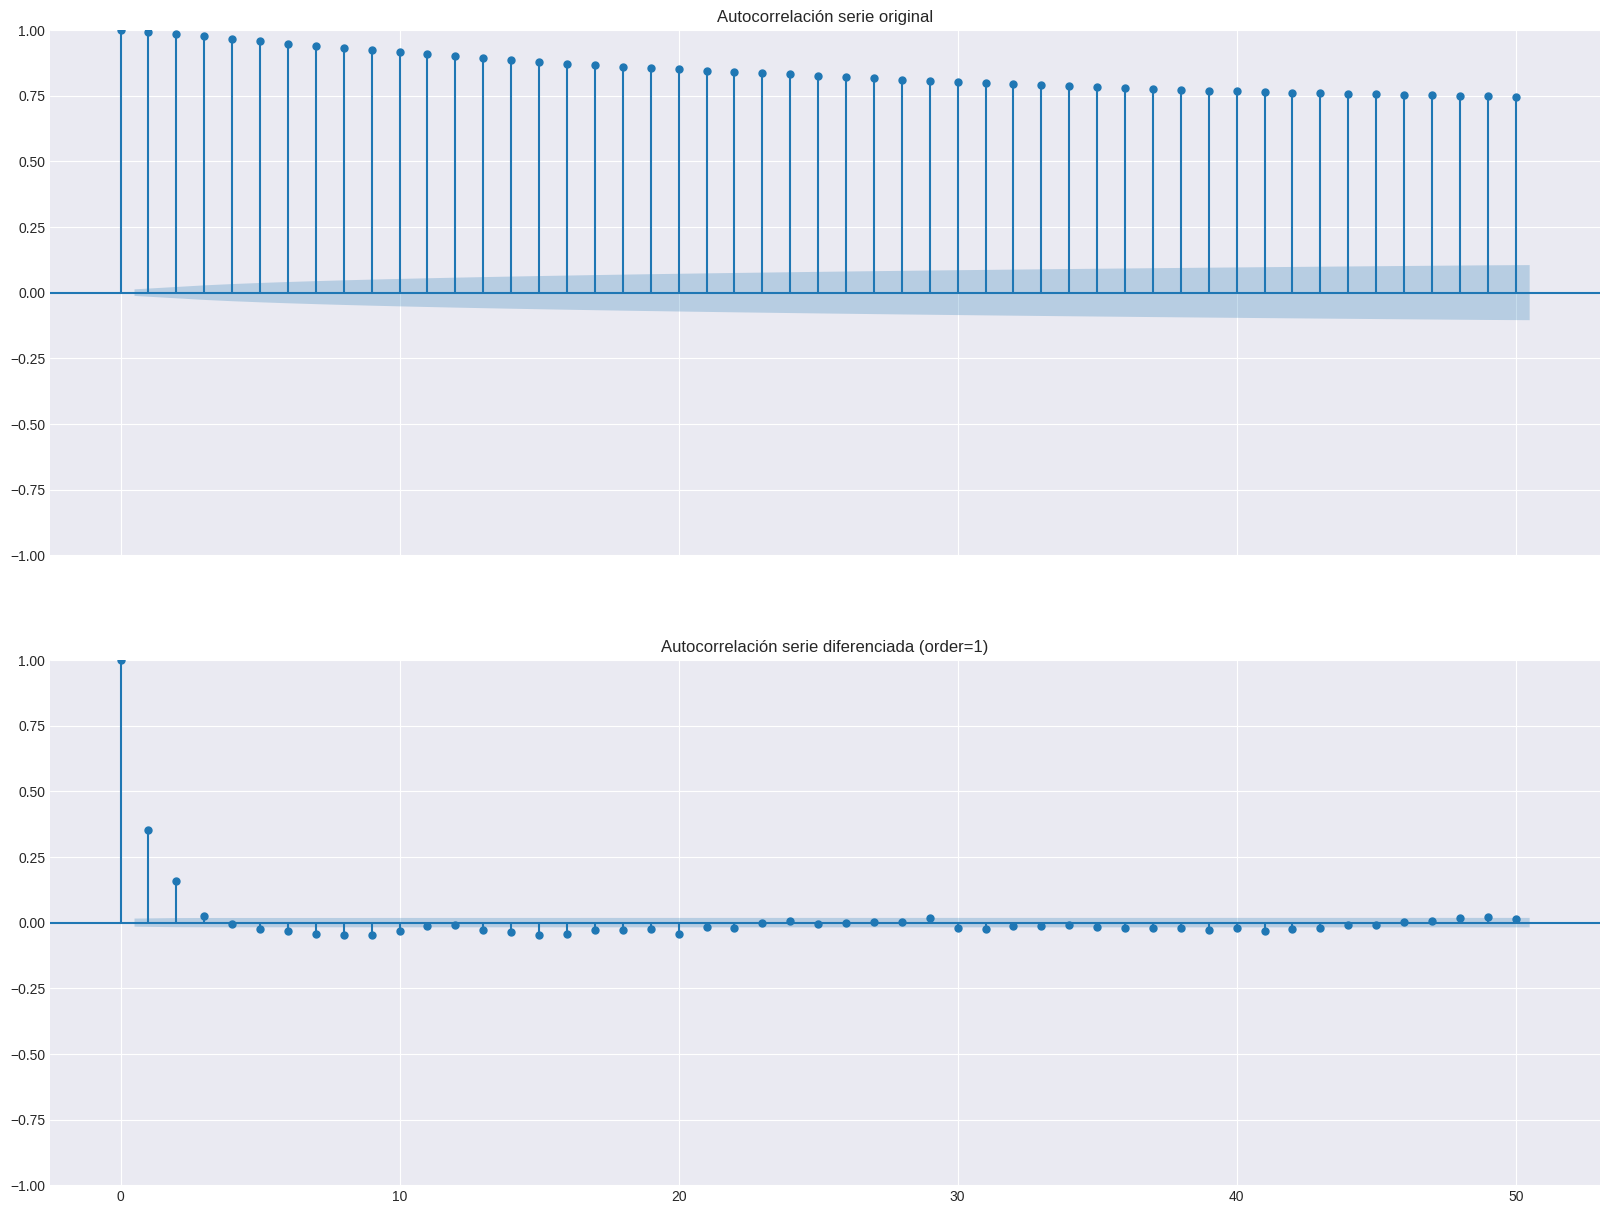

In [ ]:
#Analisis de autocorrelacion

# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,15), sharex=True)
plot_acf(datos, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)');

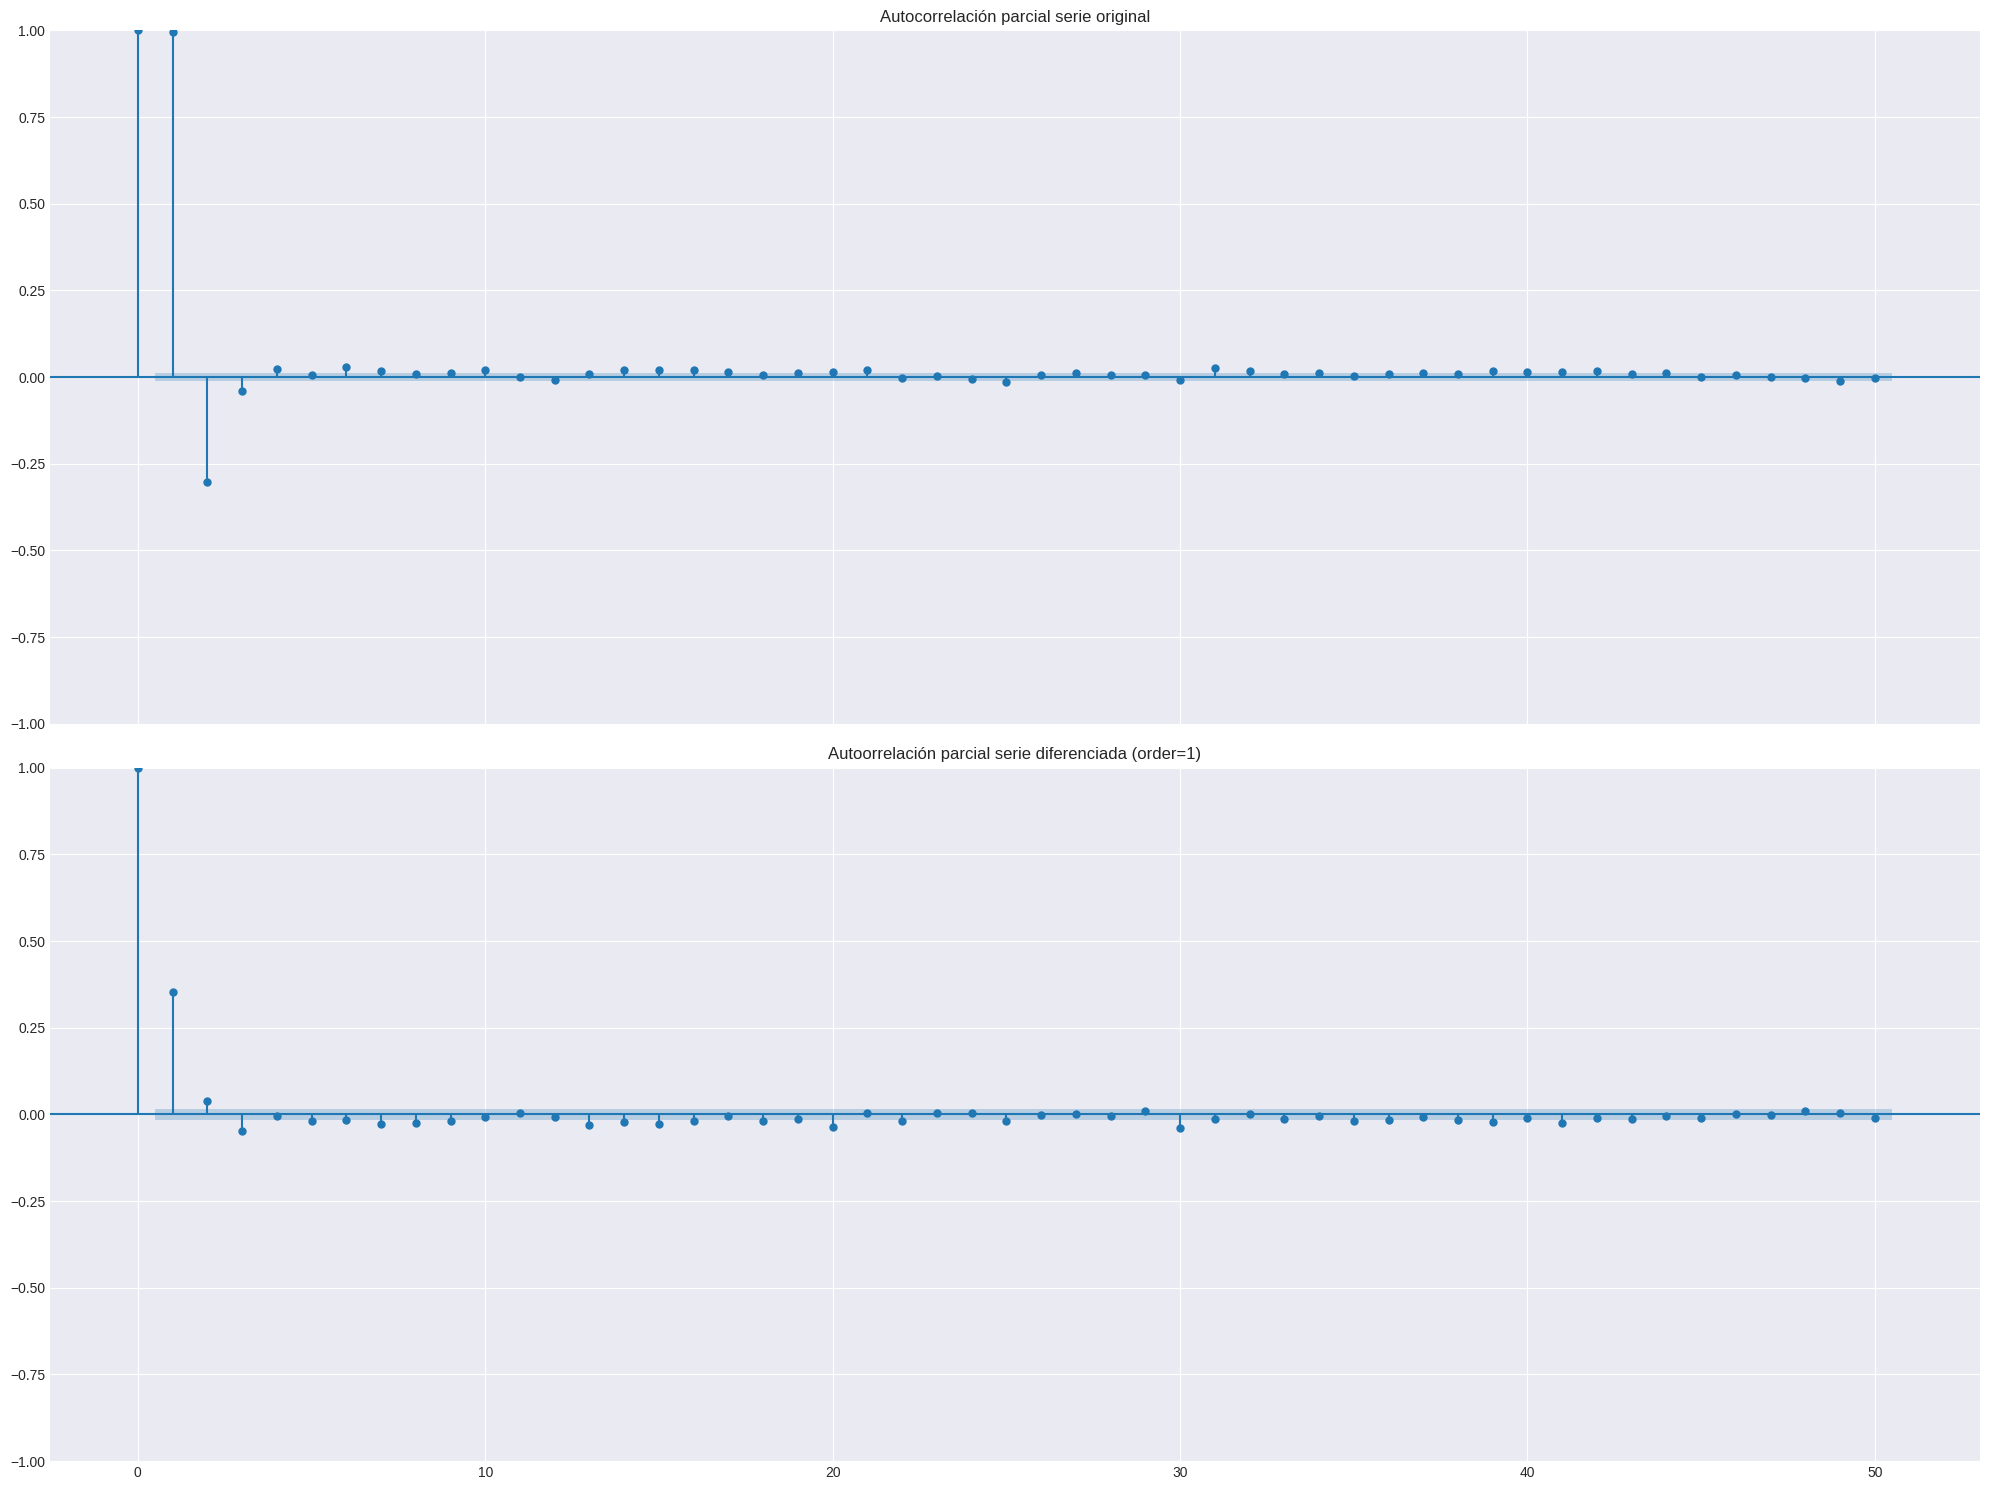

In [ ]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,15), sharex=True)
plot_pacf(datos, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
plt.tight_layout();

In [ ]:
# Descomposición de la serie original y la serie diferenciada
# ==============================================================================
# datos.index = pd.DatetimeIndex(datos.index, freq='H')
#Pasar datos de horas a meses 
res_decompose = seasonal_decompose(datos, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(datos_diff_1, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20,15), sharex=True)
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original', fontsize=12)
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad', fontsize=12)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos', fontsize=12)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=1)', fontsize=12)
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia', fontsize=12)
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad', fontsize=12)
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos', fontsize=12)
fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
fig.tight_layout();

In [ ]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
datos_diff_1_12 = datos_train.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(datos_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(datos_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -30.252739749397488, p-value: 0.0
KPSS Statistic: 0.0011338534293883437, p-value: 0.1


In [ ]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = SARIMAX(endog = datos_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
modelo_res.summary()

/home/alumno/anaconda3/envs/pytorch_ia4flood/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/alumno/anaconda3/envs/pytorch_ia4flood/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:              NIVEL_RIO_Aitzu-Urola   No. Observations:                15919
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               49034.926
Date:                            Wed, 14 Aug 2024   AIC                         -98059.851
Time:                                    13:14:40   BIC                         -98021.479
Sample:                                03-16-1999   HQIC                        -98047.156
                                     - 01-07-2001                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3460      0.005     71.738      0.000       0.337       0.355
ma.L1          0.0096      0.006      1.706      0.088      -0.001       0.021
ar.S.L12      -0.0088      0.007     -1.331      0.183      -0.022       0.004
ma.S.L12      -0.9965      0.001   -831.331      0.000      -0.999      -0.994
sigma2         0.0001   1.26e-07    988.218      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   4.79   Jarque-Bera (JB):          54100473.50
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               3.56   Skew:                             8.17
Prob(H) (two-sided):                  0.00   Kurtosis:                       288.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Predicción
# ==============================================================================
predicciones_statsmodels = modelo_res.get_forecast(steps=len(datos_test)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels.head(4))

2001-01-08 00:00:00    0.473984
2001-01-08 01:00:00    0.479263
2001-01-08 02:00:00    0.480576
2001-01-08 03:00:00    0.480200
Freq: H, Name: predicciones_statsmodels, dtype: float64

In [ ]:
# Modelo SARIMAX con skforecast.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
modelo.fit(y=datos_train)
modelo.summary()
warnings.filterwarnings("default")

/home/alumno/anaconda3/envs/pytorch_ia4flood/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/alumno/anaconda3/envs/pytorch_ia4flood/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Predictión
# ==============================================================================
predicciones_skforecast = modelo.predict(steps=len(datos_test))
display(predicciones_skforecast.head(4))

,pred
2001-01-08 00:00:00,0.473984
2001-01-08 01:00:00,0.479263
2001-01-08 02:00:00,0.480576
2001-01-08 03:00:00,0.480200


In [ ]:
# Modelo SARIMAX con pdmarima.Sarimax
# ==============================================================================
modelo = ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
modelo.fit(y=datos_train)
modelo.summary()

/home/alumno/anaconda3/envs/pytorch_ia4flood/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/alumno/anaconda3/envs/pytorch_ia4flood/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                15919
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               48999.192
Date:                            Wed, 14 Aug 2024   AIC                         -97986.385
Time:                                    13:18:36   BIC                         -97940.338
Sample:                                03-16-1999   HQIC                        -97971.151
                                     - 01-07-2001                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.779e-06   2.04e-06     -0.872      0.383   -5.78e-06    2.22e-06
ar.L1          0.3392      0.005     64.218      0.000       0.329       0.350
ma.L1         -0.0143      0.006     -2.385      0.017      -0.026      -0.003
ar.S.L12      -0.0026      0.006     -0.420      0.675      -0.015       0.010
ma.S.L12      -0.9824      0.002   -566.814      0.000      -0.986      -0.979
sigma2         0.0001   1.49e-07    824.142      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   3.57   Jarque-Bera (JB):          52875714.33
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               3.59   Skew:                             8.28
Prob(H) (two-sided):                  0.00   Kurtosis:                       284.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Prediction
# ==============================================================================
predicciones_pdmarima = modelo.predict(len(datos_test))
predicciones_pdmarima.name = 'predicciones_pdmarima'
display(predicciones_pdmarima.head(4))

2001-01-08 00:00:00    0.473098
2001-01-08 01:00:00    0.477378
2001-01-08 02:00:00    0.478011
2001-01-08 03:00:00    0.477536
Freq: H, Name: predicciones_pdmarima, dtype: float64

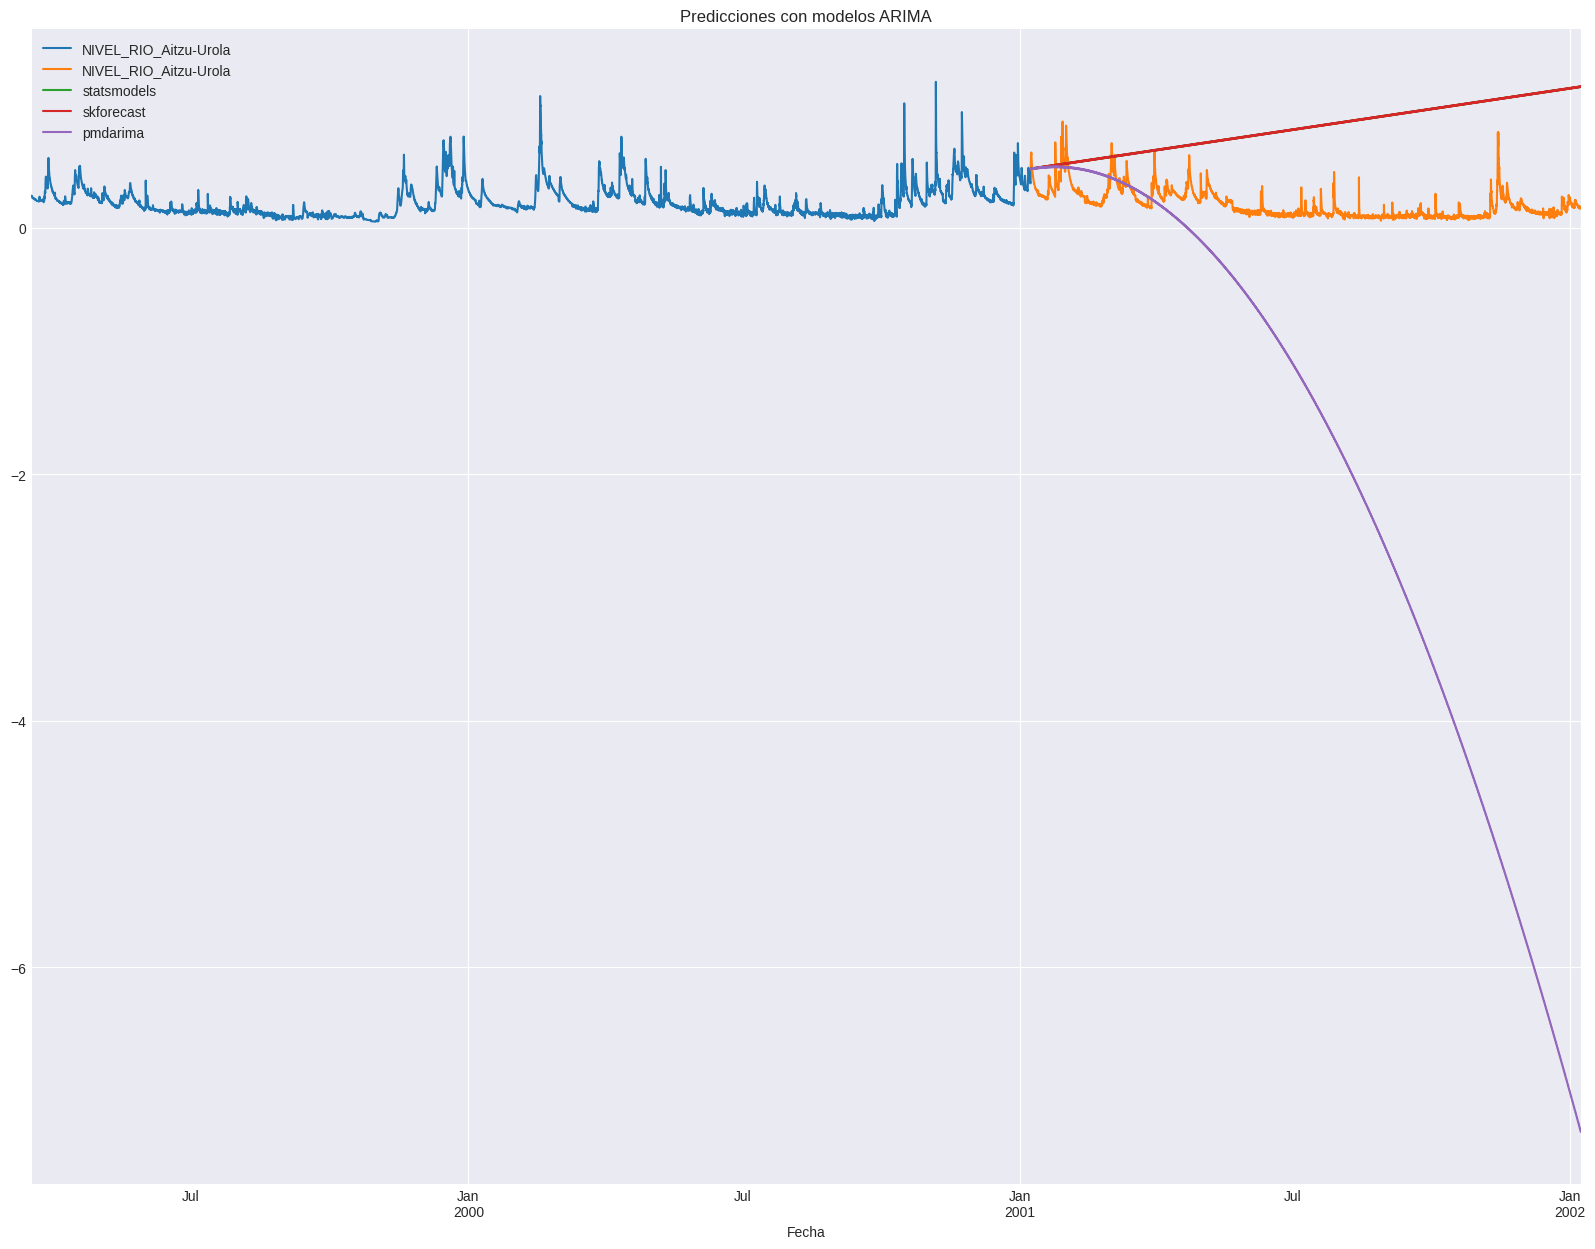

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(20,15))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones_statsmodels.plot(ax=ax, label='statsmodels')
predicciones_skforecast.columns = ['skforecast']
predicciones_skforecast.plot(ax=ax, label='skforecast')
predicciones_pdmarima.plot(ax=ax, label='pmdarima')
ax.set_title('Predicciones con modelos ARIMA')
ax.legend();

In [ ]:
# Modelo ARIMA con ForecasterSarimax y skforecast Sarimax
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
             )
datos_train = pd.Series(datos_train)
forecaster.fit(y=datos_train, suppress_warnings=True)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# # Predicción
datos_test = pd.Series(datos_test.squeeze())
predicciones = forecaster.predict(steps=len(datos_test))
predicciones.head(4)

/home/alumno/anaconda3/envs/pytorch_ia4flood/lib/python3.8/site-packages/skforecast/utils/utils.py:1120: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


TypeError: Expected index of type <class 'pandas.core.indexes.datetimes.DatetimeIndex'> for `last_window`. Got <class 'pandas.core.indexes.range.RangeIndex'>.

In [ ]:
# Backtest forecaster
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                maxiter=200
                            )
             )
metrica, predicciones = backtesting_sarimax(
                            forecaster            = forecaster,
                            y                     = datos_train,
                            initial_train_size    = len(datos_train),
                            fixed_train_size      = False,
                            steps                 = 12,
                            metric                = 'mean_absolute_error',
                            refit                 = True,
                            n_jobs                = "auto",
                            suppress_warnings_fit = True,
                            verbose               = True,
                            show_progress         = True
                        )
display(metrica)
display(predicciones.head(4))

ValueError: If used, `initial_train_size` must be an integer smaller than the length of `y` (15919).

In [ ]:
# Gráfico predicciones de backtesting
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
datos.loc[fin_train:].plot(ax=ax, label='test')
predicciones.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMAX')
ax.legend();

In [ ]:
# Train-validation-test
# ======================================================================================
fin_train = '1976-01-01 23:59:59'
fin_val = '1984-01-01 23:59:59'
print(
    f"Fechas entrenamiento : {datos.index.min()} --- {datos.loc[:fin_train].index.max()}  "
    f"(n={len(datos.loc[:fin_train])})"
)
print(
    f"Fechas validacion    : {datos.loc[fin_train:].index.min()} --- {datos.loc[:fin_val].index.max()}  "
    f"(n={len(datos.loc[fin_train:fin_val])})"
)
print(
    f"Fechas test          : {datos.loc[fin_val:].index.min()} --- {datos.index.max()}  "
    f"(n={len(datos.loc[fin_val:])})"
)

# Gráfico
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
datos.loc[:fin_train].plot(ax=ax, label='entrenamiento')
datos.loc[fin_train:fin_val].plot(ax=ax, label='validación')
datos.loc[fin_val:].plot(ax=ax, label='test')
ax.set_title('Consumo mensual combustible España')
ax.legend();